In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.layers as tfl
import matplotlib.pyplot as plt
from PIL import Image as im

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_train = tf.reshape(x_train, (-1, 784))
x_test = tf.reshape(x_test, (-1, 784))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [4]:
images_binary = (x_train > 0.2).numpy() * 1
images_binary = images_binary[:1000,:]
print(images_binary.shape)

(1000, 784)


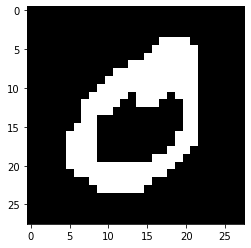

In [5]:
a = 21
i = im.fromarray(255 * images_binary[a,:].reshape(28,28))
plt.imshow(i)
plt.show()

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(np.clip(-x, -50, 50)))

def binary_stochastic(x):
    return (x > np.random.rand(x.shape[0], x.shape[1])) * 1

def update (input_vector, weights):
    updated = sigmoid(np.dot(weights, input_vector))
    updated = binary_stochastic(updated)
    return updated

def contrastive_divergence (vis, num_steps, weights):
    new_visible = vis.copy()
    for step in range(num_steps):
        hidden = update(new_visible, weights)
        if step == 0:
            data_joint_activity = hidden * vis.T
        reconstruction = update(hidden, weights.T)
        hidden = update(reconstruction, weights)
        new_visible = update(hidden, weights.T)
        if step == num_steps - 1:
            model_joint_activity = hidden * reconstruction.T
    return data_joint_activity, model_joint_activity, new_visible

def create_fantasy_particles(num, vis):
    
    particles = np.random.rand(num, vis)
    particles = (particles > 0.7) * 1
    return particles
    

def train (input_data, n_h, epochs = 100, beta = 0.99, epsilon = 0.01, curiosity = 0.9):
    
    #input_data must have shape (m, n_v)
    
    weights = np.random.randn(n_h, input_data.shape[1]) * 0.1
    loss = input_data.shape[1]
    num_particles = 100
    particles = create_fantasy_particles(num_particles, input_data.shape[1])
    cd = 1
    
    for epoch in range(epochs):
        
        for sample in range(input_data.shape[0]):
            data = input_data[sample, :].reshape(-1,1)
            fantasy = particles[sample % num_particles, :].reshape(-1,1)
            data_joint_activity, model_joint_activity, modeled_data = contrastive_divergence(data, cd, weights)
            _, distant_model_joint_activity, new_fantasy = contrastive_divergence(fantasy, cd, weights)
            loss = beta  * loss + (1 - beta) * np.sum(np.abs(data_joint_activity - model_joint_activity))
            negative_phase = (1 - curiosity) * model_joint_activity + curiosity * distant_model_joint_activity
            weights += epsilon * (data_joint_activity - negative_phase)
            particles[sample % num_particles,:] = new_fantasy.reshape(1,-1)

        if epoch % 10 == 0:
            print(' Epoch:' + str(epoch) + '    Loss: ' + str(loss))
            t = im.fromarray(255 * data.reshape(28,28))
            m = im.fromarray(255 * modeled_data.reshape(28,28))
            plt.subplot(1, 2, 1)
            plt.imshow(t)
            plt.subplot(1, 2, 2)
            plt.imshow(m)
            plt.show() 
        
    print(' End Loss: ' + str(loss))
    
    return weights
            

def test (random_start, num_cd, weights):
    
    model = random_start.copy()
    m = im.fromarray(255 * model.reshape(28,28))
    plt.imshow(m)
    plt.show()
    
    for i in range(num_cd):
        _,_, model = contrastive_divergence(model, 1, weights)
        if i % (1 + int(num_cd/10)) == 0:
            m = im.fromarray(255 * model.reshape(28,28))
            plt.imshow(m)
            plt.show()

 Epoch:0    Loss: 21775.16734317487


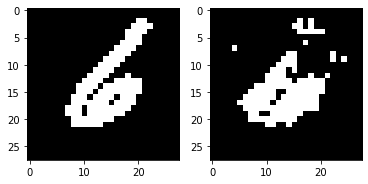

 Epoch:10    Loss: 8809.30849268599


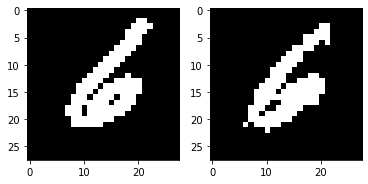

 End Loss: 6890.377209231131


In [7]:
weights = train(images_binary, n_h = 1000, epochs = 20)

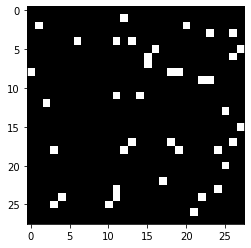

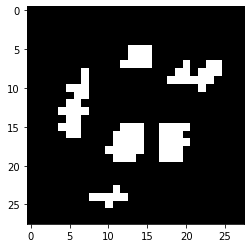

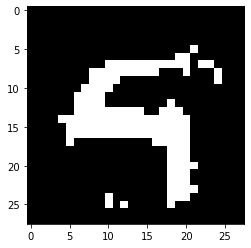

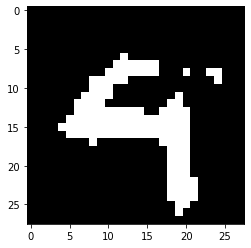

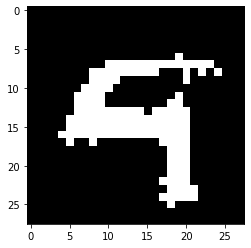

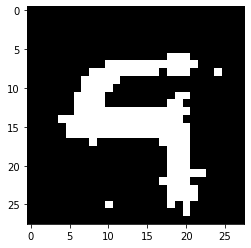

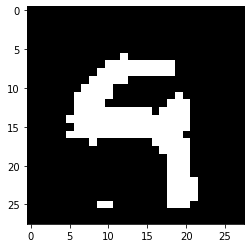

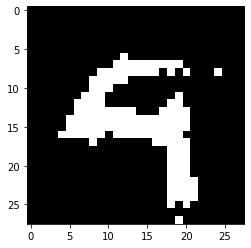

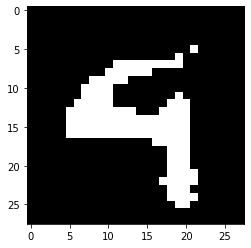

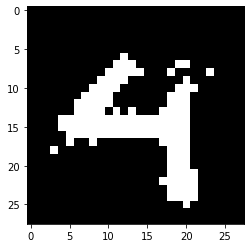

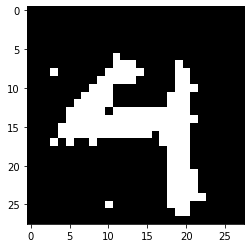

In [17]:
# recontruction of noisy data
# a = 74
# test_picture = images_binary[a, :].reshape(-1,1)
# negative_mask = np.random.randint(0, 3, size = (784,1)) - 1
# negative_mask = (negative_mask > 0) * 1
# test(negative_mask * test_picture, 10, weights)

# reconstruction from random fantasy
random_start = (np.random.rand(784,1) > 0.95) * 1 
test(random_start, 200, weights)